# Intent Classification using Keras

In [203]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [251]:
# Data Processing - Main
import numpy as np
import pandas as pd
import re

# Data Processing - Tokenizer and Encoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk import word_tokenize
from sklearn.preprocessing import OneHotEncoder

# Data Processing - Splitting
from sklearn.model_selection import train_test_split

# Visualization
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

# Machine Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Bidirectional, LSTM, Dropout
from tensorflow.compat.v1.keras.layers import CuDNNLSTM

In [205]:
# test gpu availability
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [206]:
RANDOM_SEED = 13517048
np.random.seed(RANDOM_SEED)

## Data Cleaning

In [207]:
data = pd.read_csv("nlu.csv")
data.head(10)

,text,intent
0,mau absen 11-14 februari 2020,absence
1,mau absen 11 - 14 februari 2020,absence
2,sick leave besok,absence
3,aku mau absence besok,absence
4,change working hours besok,absence
5,change working hour besok,absence
6,absen besok,absence
7,change working hours,absence
8,sick leave,absence
9,mau absen tanggal 10-11 januari 2012,absence


In [208]:
# Clean data:
#   - Strip data from special characters
#   - Tokenize words
#   - Lowercase all word
def clean_data(text_data):
  words = []
  for sentence in text_data:
    clean = re.sub(r'[^ a-z A-Z 0-9]', " ", sentence)
    tokenized_words = word_tokenize(clean)

    words.append([word.lower() for word in tokenized_words])

  return words

In [209]:
# Get max length of every word in words
def get_max_length(words):
  return len(max(words, key = len))

In [210]:
filters = '!"#$%&()*+,-./:;<=>?@[\]^_`{|}~'

def create_tokenizer(words):
  token = Tokenizer(filters = filters)
  token.fit_on_texts(words)
  return token

In [211]:
def create_train_data(text_data):
  # Encoding document
  token = create_tokenizer(text_data)
  sequences = token.texts_to_sequences(text_data)

  max_length = get_max_length(sequences)
  return pad_sequences(sequences, maxlen=max_length, padding="post")

In [212]:
def onehot_encode(data):
  encoder = OneHotEncoder(sparse=False)
  return encoder.fit_transform(data)

In [213]:
cleaned_data = clean_data(data['text'])

In [214]:
tokenizer = create_tokenizer(cleaned_data)
MAX_LENGTH = get_max_length(cleaned_data)
VOCAB_SIZE = len(tokenizer.word_index) + 1

In [215]:
train_data = create_train_data(cleaned_data)
test_data = onehot_encode(data['intent'].values.reshape(-1, 1))

x_train, x_val, y_train, y_val = train_test_split(train_data, test_data, test_size = 0.2)

## Machine Learning Modeling

In [252]:
model = Sequential()

model.add(Embedding(VOCAB_SIZE, 512, input_length=MAX_LENGTH, trainable=False))
model.add(Bidirectional(LSTM(512)))
model.add(Dense(32, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(32, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(y_train.shape[1], activation = "softmax"))

In [253]:
model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 23, 512)           362496    
_________________________________________________________________
bidirectional_9 (Bidirection (None, 1024)              4198400   
_________________________________________________________________
dense_21 (Dense)             (None, 32)                32800     
_________________________________________________________________
dropout_12 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_13 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 103)             

### Model Train

In [254]:
# Fit constants

EPOCHS = 250
BASIZE = 32

In [255]:
history = model.fit(x_train, y_train, epochs = EPOCHS, batch_size = BASIZE, validation_data = (x_val, y_val))

Epoch 1/250
39/39 [==============================] - 3s 70ms/step - loss: 4.6148 - accuracy: 0.0179 - val_loss: 4.5373 - val_accuracy: 0.0261
Epoch 2/250
39/39 [==============================] - 1s 33ms/step - loss: 4.5391 - accuracy: 0.0277 - val_loss: 4.4482 - val_accuracy: 0.0456
Epoch 3/250
39/39 [==============================] - 1s 33ms/step - loss: 4.4346 - accuracy: 0.0301 - val_loss: 4.2683 - val_accuracy: 0.0651
Epoch 4/250
39/39 [==============================] - 1s 33ms/step - loss: 4.3221 - accuracy: 0.0423 - val_loss: 4.1387 - val_accuracy: 0.0651
Epoch 5/250
39/39 [==============================] - 1s 33ms/step - loss: 4.2183 - accuracy: 0.0521 - val_loss: 4.0889 - val_accuracy: 0.0651
Epoch 6/250
39/39 [==============================] - 1s 33ms/step - loss: 4.1122 - accuracy: 0.0513 - val_loss: 3.9777 - val_accuracy: 0.0684
Epoch 7/250
39/39 [==============================] - 1s 34ms/step - loss: 4.0296 - accuracy: 0.0643 - val_loss: 3.9077 - val_accuracy: 0.0814
Epoch 

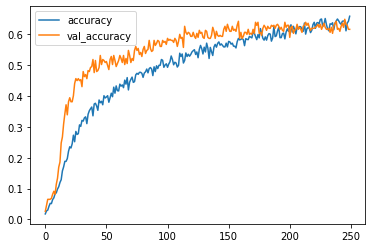

In [256]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.legend(['accuracy', 'val_accuracy'])

### Model Predict

In [257]:
def padding_doc(encoded_doc, max_length):
  return(pad_sequences(encoded_doc, maxlen = max_length, padding = "post"))

In [258]:
intent_map = {}
for intent, onehot_intent in zip(data['intent'].values, test_data):
  if (intent not in intent_map):
    intent_map[intent] = list(onehot_intent).index(1)

In [259]:
def predict(text):
  # Clean the text first
  cleaned_text = re.sub(r'[^ a-z A-Z 0-9]', " ", text)
  test_word = word_tokenize(cleaned_text)
  test_word = [w.lower() for w in test_word]
  test_ls = tokenizer.texts_to_sequences(test_word)

  # Check for unknown words
  if [] in test_ls:
    test_ls = list(filter(None, test_ls))
    
  test_ls = np.array(test_ls).reshape(1, len(test_ls))
  x = padding_doc(test_ls, max_length)
  
  prediction_result = model.predict(x)
  prediction_result = prediction_result[0]

  # convert prediction result to intent word
  unique_intents = np.array(list(set(data['intent'])))

  # sort value by intent ranking
  intent_ranking = {}
  for each_intent in unique_intents:
    intent_ranking[each_intent] = prediction_result[intent_map[each_intent]]

  sorted_intent_ranking = sorted(intent_ranking.items(), key=lambda kv: kv[1], reverse=True)

  print("Intent Ranking:")
  for each_intent in sorted_intent_ranking:
    print(each_intent[0] + "= " + str(each_intent[1]) + " confidence")

In [262]:
predict("berapa nomor npwp saya")

Intent Ranking:
ask_npwp= 0.999974 confidence
ask_absence_attendance_status_policy= 1.8835635e-05 confidence
ask_bpjs_membership= 6.9913053e-06 confidence
ask_holiday= 1.1581014e-07 confidence
ask_identity_card= 2.0955901e-10 confidence
ask_subordinate= 2.6900353e-11 confidence
ask_company= 2.2417858e-11 confidence
ask_location= 6.2787763e-13 confidence
approval_status= 3.8045877e-14 confidence
ask_shift= 1.3207748e-14 confidence
ask_allowance= 9.716985e-18 confidence
approval= 7.6578763e-19 confidence
ask_personal_detail= 7.5749856e-19 confidence
leave_cancellation_ask_approval_status= 8.993553e-21 confidence
absence= 1.2729709e-21 confidence
help= 5.9794874e-22 confidence
leave_entry_ask_dates= 2.6074233e-24 confidence
ask_ump= 2.429876e-24 confidence
ask_bpjs_treatment_class= 1.4075977e-24 confidence
ask_employment_detail= 3.1239153e-25 confidence
register_user_ask_tenant= 5.509286e-26 confidence
approval_ask_parameter= 1.8159443e-27 confidence
ask_additional_income_prerequisite_aft